In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import random

from models.hgd_model import Generator, Discriminator, DHead, QHead, VAEncoder
from dataloader import get_data
from utils import *
from config import params

if(params['dataset'] == 'MNIST'):
    from models.mnist_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'SVHN'):
    from models.svhn_model import Generator, Discriminator, DHead, QHead, VAEncoder
elif(params['dataset'] == 'CelebA'):
    from models.celeba_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'FashionMNIST'):
    from models.mnist_model import Generator, Discriminator, DHead, QHead
elif(params['dataset'] == 'HGD'):
    from models.hgd_model import Generator, Discriminator, DHead, QHead,VAEncoder


In [2]:

# Set random seed for reproducibility.
seed = 1123
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

# Use GPU if available.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
print(device, " will be used.\n")

dataloader = get_data(params['dataset'], params['batch_size'])

# Set appropriate hyperparameters depending on the dataset used.
# The values given in the InfoGAN paper are used.
# num_z : dimension of incompressible noise.
# num_dis_c : number of discrete latent code used.
# dis_c_dim : dimension of discrete latent code.
# num_con_c : number of continuous latent code used.
if(params['dataset'] == 'MNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2
elif(params['dataset'] == 'SVHN'):
    params['num_z'] = 124
    params['num_dis_c'] = 4
    params['dis_c_dim'] = 10
    params['num_con_c'] = 4
elif(params['dataset'] == 'CelebA'):
    params['num_z'] = 128
    params['num_dis_c'] = 10
    params['dis_c_dim'] = 10
    params['num_con_c'] = 0
elif(params['dataset'] == 'FashionMNIST'):
    params['num_z'] = 62
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2
elif(params['dataset'] == 'HGD'):
    params['num_z'] = 228
    params['num_dis_c'] = 1
    params['dis_c_dim'] = 10
    params['num_con_c'] = 2

# Plot the training images.
sample_batch = next(iter(dataloader))
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(
    sample_batch[0].to(device)[ : 100], nrow=10, padding=2, normalize=True).cpu(), (1, 2, 0)))
plt.savefig('results/Training Images {}'.format(params['dataset']))
plt.close('all')


Random Seed:  1123
cuda:0  will be used.



In [3]:

# Initialise the network.
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

discriminator = Discriminator().to(device)
discriminator.apply(weights_init)
print(discriminator)

netD = DHead().to(device)
netD.apply(weights_init)
print(netD)

netQ = QHead().to(device)
netQ.apply(weights_init)
print(netQ)

vae = VAEncoder().to(device)
vae.apply(weights_init)
print(vae)
# Loss for discrimination between real and fake images.
criterionD = nn.BCELoss()
# Loss for discrete latent code.
criterionQ_dis = nn.CrossEntropyLoss()
# Loss for continuous latent code.
criterionQ_con = NormalNLLLoss()
# Loss for image
criterionRECON = nn.L1Loss()
# Loss for latent encoding
criterionLAT = nn.L1Loss()
# Adam optimiser is used.
optimD = optim.RMSprop([{'params': discriminator.parameters()}, {'params': netD.parameters()}], lr=params['learning_rate_d'])
optimG = optim.RMSprop([{'params': vae.parameters()},{'params': netG.parameters()}, {'params': netQ.parameters()}], lr=params['learning_rate_g'])

# Fixed Noise
z = torch.randn(100, params['num_z'], 1, 1, device=device)
fixed_noise = z
if(params['num_dis_c'] != 0):
    idx = np.arange(params['dis_c_dim']).repeat(10)
    dis_c = torch.zeros(100, params['num_dis_c'], params['dis_c_dim'], device=device)
    for i in range(params['num_dis_c']):
        dis_c[torch.arange(0, 100), i, idx] = 1.0

    dis_c = dis_c.view(100, -1, 1, 1)

    fixed_noise = torch.cat((fixed_noise, dis_c), dim=1)

if(params['num_con_c'] != 0):
    con_c = torch.rand(100, params['num_con_c'], 1, 1, device=device) * 2 - 1
    fixed_noise = torch.cat((fixed_noise, con_c), dim=1)

real_label = 1
fake_label = 0

# List variables to store results pf training.
img_list = []
G_losses = []
D_losses = []




Generator(
  (tconv1): ConvTranspose2d(240, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(4, 4), stride=(

In [4]:
print("-"*25)
print("Starting Training Loop...\n")
print('Epochs: %d\nDataset: {}\nBatch Size: %d\nLength of Data Loader: %d'.format(params['dataset']) % (params['num_epochs'], params['batch_size'], len(dataloader)))
print("-"*25)

start_time = time.time()
iters = 0

for epoch in range(params['num_epochs']):
    epoch_start_time = time.time()

    for i, (data, gt_label) in enumerate(dataloader, 0):
        # Get batch size
        b_size = data.size(0)
        # Transfer data tensor to GPU/CPU (device)
        real_data = data.to(device)

        # Updating discriminator and DHead
        optimD.zero_grad()
        # Real data
        label = torch.full((b_size, ), real_label, device=device,dtype=torch.float32)
        output1 = discriminator(real_data)
        # print(output1.dtype)
        # with torch.no_grad():
        #     print(netD(output1).dtype)
        probs_real = netD(output1).view(-1)
        # print(label.dtype,probs_real.dtype)
        loss_real = criterionD(probs_real, label)
        # Calculate gradients.
        loss_real.backward()

        # Fake data
        label.fill_(fake_label)
        # _, idx = noise_sample(params['num_dis_c'], params['dis_c_dim'], params['num_con_c'], params['num_z'], b_size, device)
        vae_mu_real,vae_var_real= vae(real_data)
        noise = (vae_mu_real+ torch.randn_like(vae_var_real)*torch.sqrt(vae_var_real.exp())).view(b_size,-1,1,1)
        # print(gt_label.shape)
        idx = gt_label.reshape(params['num_dis_c'], b_size) #np.zeros((params['num_dis_c'], b_size))
        if(params['num_dis_c'] != 0):
            dis_c = torch.zeros(b_size, params['num_dis_c'], params['dis_c_dim'], device=device)
            for i in range(params['num_dis_c']):
                #idx = _ #np.random.randint(params['dis_c_dim'], size=b_size)
                dis_c[torch.arange(0, b_size), i, idx] = 1.0

            dis_c = dis_c.view(b_size, -1, 1, 1)

            noise = torch.cat((noise, dis_c), dim=1)
        # print(idx,dis_c)
        if(params['num_con_c'] != 0):
            con_c = torch.rand(b_size, params['num_con_c'], 1, 1, device=device) * 2 - 1
            noise = torch.cat((noise, con_c), dim=1)
        fake_data = netG(noise)
        output2 = discriminator(fake_data.detach())
        probs_fake = netD(output2).view(-1)
        loss_fake = criterionD(probs_fake, label)
        # Calculate gradients.
        loss_fake.backward()

        # Net Loss for the discriminator
        D_loss = loss_real + loss_fake
        # Update parameters
        optimD.step()

        # Updating Generator and QHead
        optimG.zero_grad()

        # Fake data treated as real.
        output = discriminator(fake_data)
        vae_mu_fake,vae_var_fake = vae(fake_data)
        label.fill_(real_label)
        probs_fake = netD(output).view(-1)
        gen_loss = criterionD(probs_fake, label)
        recon_loss = criterionRECON(fake_data,real_data)
        q_logits, q_mu, q_var = netQ(output)
        target = torch.LongTensor(idx).to(device)
        # print(target.shape, dis_c.shape)
        
        # Calculating loss for discrete latent code.
        dis_loss = 0
        # for j in range(params['num_dis_c']):
        # print(target.shape,q_logits.shape)
        dis_loss = criterionQ_dis(q_logits, target.squeeze())

        # Calculating loss for continuous latent code.
        con_loss = 0
        if (params['num_con_c'] != 0):
            con_loss = criterionQ_con(noise[:, params['num_z']+ params['num_dis_c']*params['dis_c_dim'] : ].view(-1, params['num_con_c']), q_mu, q_var)

        latent_loss = criterionLAT((vae_mu_fake+ torch.randn_like(vae_var_fake)*torch.sqrt(vae_var_fake.exp())).view(b_size,-1,1,1),
                                  (vae_mu_real+ torch.randn_like(vae_var_real)*torch.sqrt(vae_var_real.exp())).view(b_size,-1,1,1))
        
        KLD_loss  = torch.mean(-0.5 * torch.sum(1 + vae_var_real - vae_mu_real.pow(2) - vae_var_real.exp(),dim=1)).to(device)
        # print(KLD_loss)
        # Net loss for generator.
        G_loss = gen_loss + dis_loss + con_loss + recon_loss + latent_loss + KLD_loss#*0.01
        # Calculate gradients.
        G_loss.backward()
        # torch.nn.utils.clip_grad_norm_(netG.parameters(), .1)

        # Update parameters.
        optimG.step()

        # Check progress of training.
        if i != 0 and i%100 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch+1, params['num_epochs'], i, len(dataloader), 
                    D_loss.item(), G_loss.item()))

        # Save the losses for plotting.
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())

        iters += 1
    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
        % (epoch+1, params['num_epochs'], i, len(dataloader), 
        D_loss.item(), G_loss.item()))
    epoch_time = time.time() - epoch_start_time
    print("Time taken for Epoch %d: %.2fs" %(epoch + 1, epoch_time))
    # Generate image after each epoch to check performance of the generator. Used for creating animated gif later.
    with torch.no_grad():
        gen_data = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True))

    # Generate image to check performance of generator.
    if((epoch+1) == 1 or (epoch+1) %10 == 0):
        with torch.no_grad():
            gen_data = netG(fixed_noise).detach().cpu()
        plt.figure(figsize=(10, 10))
        plt.axis("off")
        plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
        plt.savefig("results/Epoch_%d_{}".format(params['dataset']) %(epoch+1))
        plt.close('all')

    # Save network weights.
    if (epoch+1) % params['save_epoch'] == 0:
        torch.save({
            'netG' : netG.state_dict(),
            'discriminator' : discriminator.state_dict(),
            'netD' : netD.state_dict(),
            'netQ' : netQ.state_dict(),
            'optimD' : optimD.state_dict(),
            'optimG' : optimG.state_dict(),
            'params' : params
            }, 'checkpoint/model_epoch_%d_{}'.format(params['dataset']) %(epoch+1))

training_time = time.time() - start_time
print("-"*50)
print('Training finished!\nTotal Time for Training: %.2fm' %(training_time / 60))
print("-"*50)

-------------------------
Starting Training Loop...

Epochs: 200
Dataset: HGD
Batch Size: 64
Length of Data Loader: 250
-------------------------
[1/200][0/250]	Loss_D: 0.1127	Loss_G: 8.4302
Time taken for Epoch 1: 5.97s
[2/200][0/250]	Loss_D: 1.0567	Loss_G: 7.5197
Time taken for Epoch 2: 5.22s
[3/200][0/250]	Loss_D: 0.0705	Loss_G: 5.6218
Time taken for Epoch 3: 5.14s
[4/200][0/250]	Loss_D: 0.0181	Loss_G: 8.3930
Time taken for Epoch 4: 5.32s
[5/200][0/250]	Loss_D: 0.1417	Loss_G: 6.4380
Time taken for Epoch 5: 5.32s
[6/200][0/250]	Loss_D: 0.1927	Loss_G: 4.2876
Time taken for Epoch 6: 5.29s
[7/200][0/250]	Loss_D: 0.0133	Loss_G: 8.4738
Time taken for Epoch 7: 5.24s
[8/200][0/250]	Loss_D: 0.0118	Loss_G: 8.6668
Time taken for Epoch 8: 5.17s
[9/200][0/250]	Loss_D: 0.1267	Loss_G: 5.4731
Time taken for Epoch 9: 5.33s
[10/200][0/250]	Loss_D: 0.0641	Loss_G: 6.0909
Time taken for Epoch 10: 5.24s
[11/200][0/250]	Loss_D: 0.0188	Loss_G: 8.3970
Time taken for Epoch 11: 5.29s
[12/200][0/250]	Loss_D: 0

MovieWriter imagemagick unavailable; using Pillow instead.


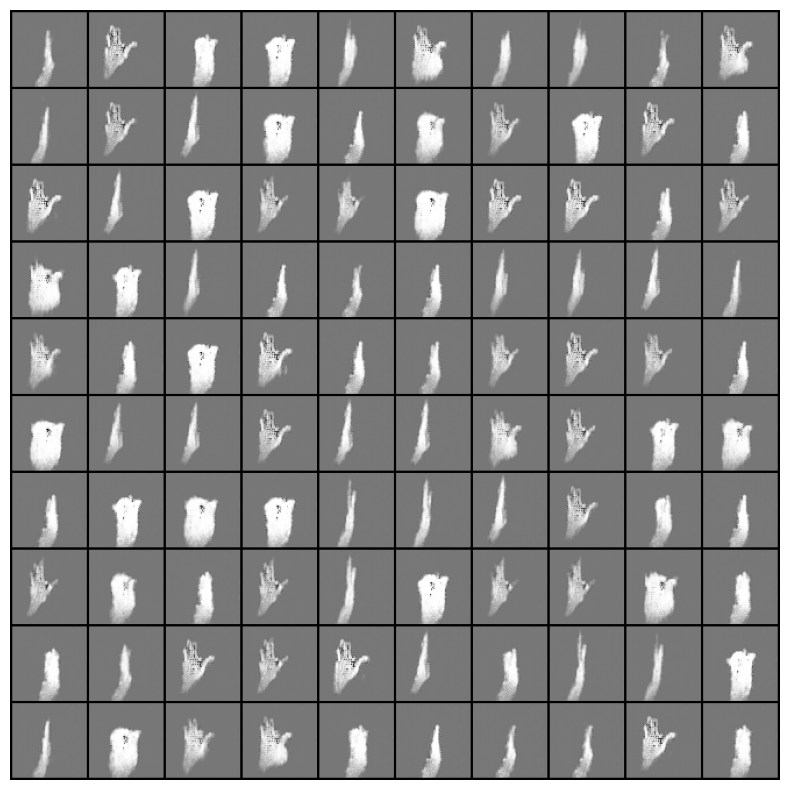

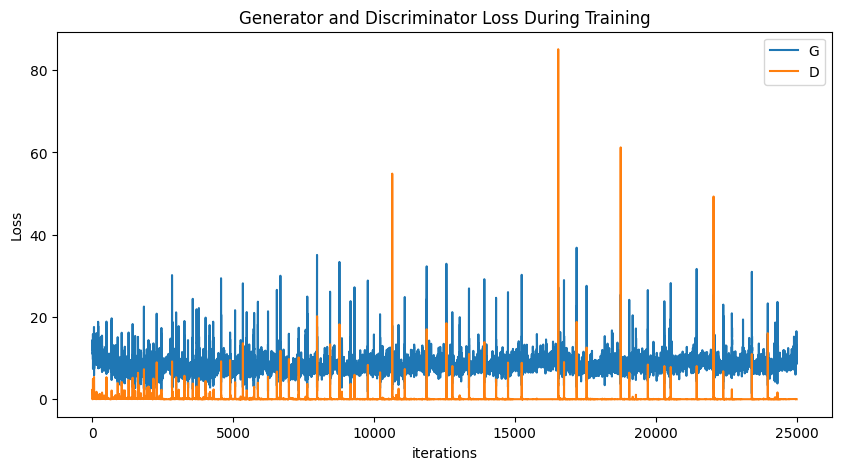

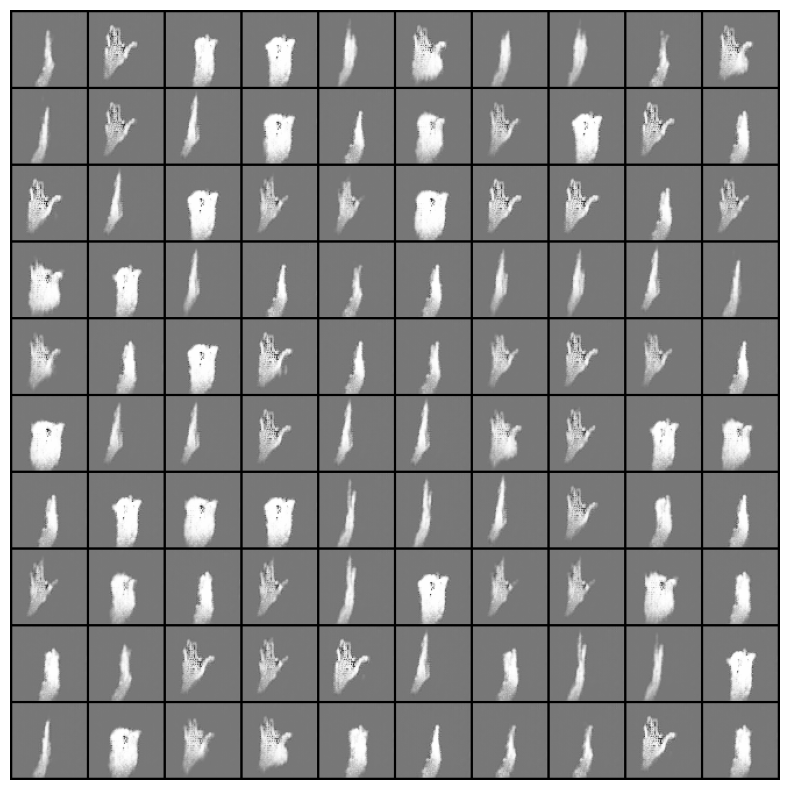

In [ ]:

# Generate image to check performance of trained generator.
with torch.no_grad():
    gen_data = netG(fixed_noise).detach().cpu()
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(gen_data, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.savefig("results/Epoch_%d_{}".format(params['dataset']) %(params['num_epochs']))

# Save network weights.
torch.save({
    'netG' : netG.state_dict(),
    'discriminator' : discriminator.state_dict(),
    'netD' : netD.state_dict(),
    'netQ' : netQ.state_dict(),
    'optimD' : optimD.state_dict(),
    'optimG' : optimG.state_dict(),
    'params' : params
    }, 'checkpoint/model_final_{}'.format(params['dataset']))


# Plot the training losses.
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("results/Loss Curve {}".format(params['dataset']))

# Animation showing the improvements of the generator.
fig = plt.figure(figsize=(10,10))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
anim = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
anim.save('results/infoGAN_{}.gif'.format(params['dataset']), dpi=80, writer='imagemagick')
plt.show()

In [ ]:
import argparse

import torch
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

# parser = argparse.ArgumentParser()
# parser.add_argument('-load_path', required=True, help='Checkpoint to load path from')
# args = parser.parse_args()

from models.hgd_model import Generator

# Load the checkpoint file
state_dict = torch.load('checkpoint/model_final_HGD')

# Set the device to run on: GPU or CPU.
device = torch.device("cuda:0" if(torch.cuda.is_available()) else "cpu")
# Get the 'params' dictionary from the loaded state_dict.
params = state_dict['params']

# Create the generator network.
netG = Generator().to(device)
# Load the trained generator weights.
netG.load_state_dict(state_dict['netG'])
print(netG)

c = np.linspace(-2, 2, 10).reshape(1, -1)
c = np.repeat(c, 10, 0).reshape(-1, 1)
c = torch.from_numpy(c).float().to(device)
c = c.view(-1, 1, 1, 1)

zeros = torch.zeros(100, 1, 1, 1, device=device)

# Continuous latent code.
c2 = torch.cat((c, zeros), dim=1)
c3 = torch.cat((zeros, c), dim=1)

idx = np.arange(10).repeat(10)
dis_c = torch.zeros(100, 10, 1, 1, device=device)
dis_c[torch.arange(0, 100), idx] = 1.0
# Discrete latent code.
c1 = dis_c.view(100, -1, 1, 1)

z = torch.randn(100, 228, 1, 1, device=device)

# To see variation along c2 (Horizontally) and c1 (Vertically)
noise1 = torch.cat((z, c1, c2), dim=1)
# To see variation along c3 (Horizontally) and c1 (Vertically)
noise2 = torch.cat((z, c1, c3), dim=1)

# Generate image.
with torch.no_grad():
    generated_img1 = netG(noise1).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img1, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

# Generate image.
with torch.no_grad():
    generated_img2 = netG(noise2).detach().cpu()
# Display the generated image.
fig = plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(generated_img2, nrow=10, padding=2, normalize=True), (1,2,0)))
plt.show()

Generator(
  (tconv1): ConvTranspose2d(240, 512, kernel_size=(2, 2), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (tconv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv5): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tconv6): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)


RuntimeError: Given transposed=1, weight of size [240, 512, 2, 2], expected input[100, 168, 1, 1] to have 240 channels, but got 168 channels instead